# 0. Installs, Imports and API Keys

In [ ]:
# RUN THIS CELL FIRST!
!pip install -q langchain==0.0.150 pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu

In [ ]:
"""!pip uninstall openai

!pip install -Iv  openai==0.27.8"""

'!pip uninstall openai\n\n!pip install -Iv  openai==0.27.8'

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

In [18]:
os.environ["OPENAI_API_KEY"] = "api key id"

# 1. Loading PDFs and chunking with LangChain

In [ ]:
# You MUST add your PDF to local files in this notebook (folder icon on left hand side of screen)

# Simple method - Split by pages
loader = PyPDFLoader("/content/attention-is-all-you-need-Paper.pdf")
pages = loader.load_and_split()
print(pages[0])

# SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
chunks = pages

page_content='Attention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.comNoam Shazeer∗\nGoogle Brain\nnoam@google.comNiki Parmar∗\nGoogle Research\nnikip@google.comJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.comAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurrence and convolutions\nentirely. Experiments on two machine translation tasks show these models to\nbe superior in quality while being more parallelizable and requiring signiﬁcan

In [ ]:
# Advanced method - Split by chunk

# Step 1: Convert PDF to text
import textract
doc = textract.process("/content/attention-is-all-you-need-Paper.pdf")

# Step 2: Save to .txt and reopen (helps prevent issues)
with open('attention_is_all_you_need.txt', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('attention_is_all_you_need.txt', 'r') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
# Result is many LangChain 'Documents' around 500 tokens or less (Recursive splitter sometimes allows more tokens to retain context)
type(chunks[0])

langchain.schema.Document

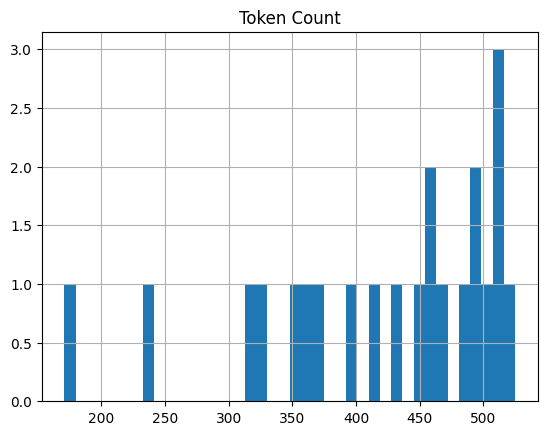

In [ ]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

# 2. Embed text and store embeddings

In [ ]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

# 3. Setup retrieval function

In [ ]:
# Check similarity search is working
query = "Who created transformers?"
docs = db.similarity_search(query)
docs[0]

Document(page_content='∗Equal contribution. Listing order is random. Jakob proposed replacing RNNs with self-attention and started\nthe effort to evaluate this idea. Ashish, with Illia, designed and implemented the ﬁrst Transformer models and\nhas been crucially involved in every aspect of this work. Noam proposed scaled dot-product attention, multi-head\nattention and the parameter-free position representation and became the other person involved in nearly every\ndetail. Niki designed, implemented, tuned and evaluated countless model variants in our original codebase and\ntensor2tensor. Llion also experimented with novel model variants, was responsible for our initial codebase, and\nefﬁcient inference and visualizations. Lukasz and Aidan spent countless long days designing various parts of and\nimplementing tensor2tensor, replacing our earlier codebase, greatly improving results and massively accelerating\nour research.\n\n†Work performed while at Google Brain.\n‡Work performed while 

In [ ]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(model="gpt-3.5-turbo-instruct",temperature=0), chain_type="stuff")

query = "Who created transformers?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

                    model was transfered to model_kwargs.
                    Please confirm that model is what you intended.


' Jakob proposed replacing RNNs with self-attention and started the effort to evaluate this idea. Ashish, with Illia, designed and implemented the ﬁrst Transformer models and has been crucially involved in every aspect of this work. Noam proposed scaled dot-product attention, multi-head attention and the parameter-free position representation and became the other person involved in nearly every detail. Niki designed, implemented, tuned and evaluated countless model variants in our original codebase and tensor2tensor. Llion also experimented with novel model variants, was responsible for our initial codebase, and efﬁcient inference and visualizations. Lukasz and Aidan spent countless long days designing various parts of and implementing tensor2tensor, replacing our earlier codebase, greatly improving results and massively accelerating our research.'

# 5. Create chatbot with chat memory (OPTIONAL)

In [ ]:
from IPython.display import display
import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(model="gpt-3.5-turbo-instruct",temperature=0.1), db.as_retriever())

                    model was transfered to model_kwargs.
                    Please confirm that model is what you intended.


In [19]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""

    if query.lower() == 'exit':
        print("Thank you for using the State of the Union chatbot!")
        return

    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))

    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the Transformers chatbot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

Welcome to the Transformers chatbot! Type 'exit' to stop.


Text(value='', placeholder='Please enter your question:')

HTML(value='<b>User:</b> what is Transformers')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Transformers are a type of neural network architecture …

HTML(value='<b>User:</b> Who created Transformer')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Noam Shazeer∗')

HTML(value='<b>User:</b> how transformer w')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Noam Shazeer and Ashish Vaswani are the creators of Tra…

HTML(value='<b>User:</b> define attent')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Attention in the Transformer architecture is a mechanis…

HTML(value='<b>User:</b> how Transformer work')

HTML(value='<b><font color="blue">Chatbot:</font></b>  The Transformer architecture is based on an encoder-dec…